# Air Entrainment Analysis Automatized


## by $\Re\in\Upsilon\sqcap\alpha$

---
<div style="text-align: right"> 
author: R.G. Ramirez de la T.

<div style="text-align: right">
start date: 14-Sep-2018 (extracted from Photron Make Analysis)

<div style="text-align: right">
last modification: 17-Sep-2018
</div>

First we need to import the functions provided by the other notebook: **Photron Analysis Functions**. To do this, we need to run this first cell and then run the cells at the bottom of this notebook after the **Classes for notebook importer** subtitle, where the importer classes are defined and the notebook is imported as a module. 

In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

Then we can import the modules we will use continuosly to make the analysis

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

Different type of data can be extracted from the edges matrixes, and different graphs can be defined also so here we separate each analysis depending on the type of data we want to extract.

## Waves Speed by cross-correlation

In this section we compare the waves in two different timesteps to make a cross-correlation and determine the wave speed. Then we make histogram of the encountered wave speeds.

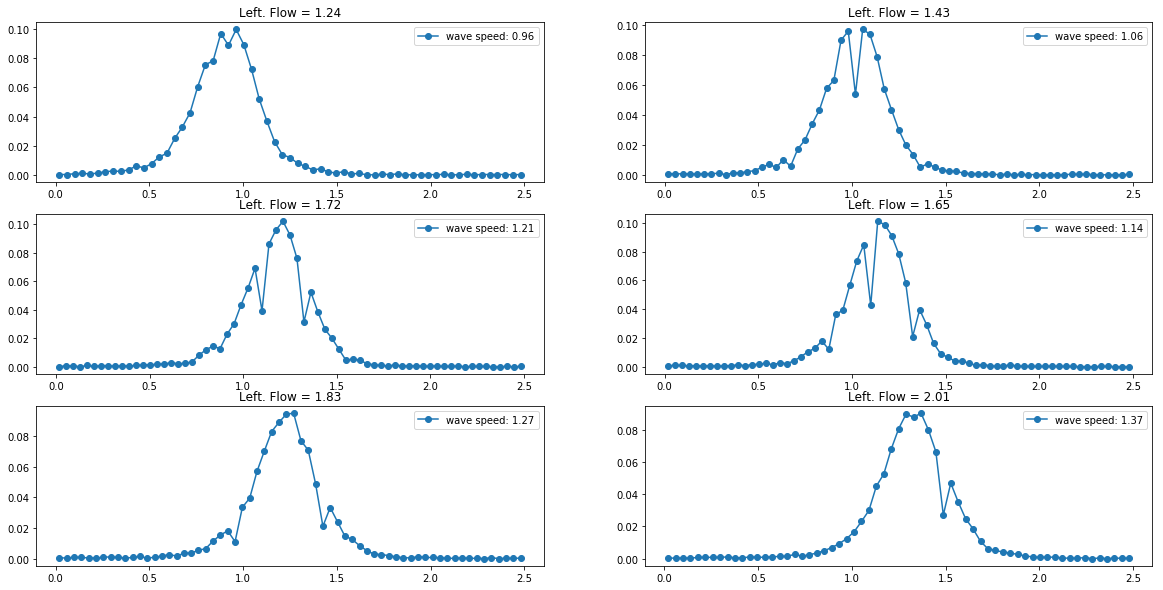

In [34]:
plt.figure(figsize=(20,10))
peaks = np.zeros(6)
stds  = np.zeros(6)
for num in range(200,206):
    name_flow = '../flowmeter/FlowMeterData_'+str(num)+'.lvm'
    t,flow = Phot.lvm_unpack(name_flow) 
    mean_flow = Phot.Mean_Flow(flow)
    txt_name_l = 'sobel_left'+str(num)+'.txt'
    data_l = np.loadtxt(txt_name_l,unpack=True)
    no_images = data_l.shape[0]
    left = np.zeros((no_images,800))
    for i in range(no_images):
        wave_l = Phot.smooth(data_l[i,:800],window_len=100,window='hanning')
        left[i,:] = wave_l
    waves_left = Phot.substract_zero_crossing_time(left)
    indexes = []
    no_waves = []
    for i in range(no_images):
        try:
            sep = Phot.Find_waves(waves_left[i,:],'left')
            indexes.append(sep)
            no_waves.append(len(sep)-1)
        except:
            indexes.append(0)
            no_waves.append(0)
    #speeds = []
    #pairs = []
    hist_speed = []
    for i in range(0,no_images-1):

        speed = []
        #pair = []
        number1 = no_waves[i]
        number2 = no_waves[i+1]
        idx = indexes[i]
        idx2 = indexes[i+1]
        if number1 == 0:
            #speeds.append(0)
            #pairs.append(0)
            continue
        if number2 == 0:
            #speeds.append(0)
            #pairs.append(0)
            continue

        for j in range(number1):

        #pair the first wave in each picture
            patch1 = np.zeros_like(waves_left[i,:])
            patch1[idx[j]:idx[j+1]] = waves_left[i,idx[j]:idx[j+1]]
            for k in range(number2):

                patch2 = np.zeros_like(waves_left[i+1,:])
                patch2[idx2[k]:idx2[k+1]] = waves_left[i+1,idx2[k]:idx2[k+1]]
                length = len(patch1)+len(patch2)
                center = length/2
                #check the crosscorrelation
                corr = (scipy.signal.correlate(patch1/patch1.std(),patch2/patch2.std()))/center
                peak = np.max(corr)
                ind = np.argmax(corr)
                if peak >= 0.80:
                    vel = center-ind
                    if vel<=0:
                        vel = 0
                    if vel > 0:
                        #speed.append(vel)
                        hist_speed.append(vel)

                    break
            if not speed:
                speed.append(0)
            #If the velocity is negative also change wave
        #pairs.append(pair)
        #speeds.append(speed)
    #scale speed to m/s
    hist_speed = np.array(hist_speed)/49.07
    hist, bins = np.histogram(hist_speed,bins='scott',range=(0,2.5))
    total_parts = len(hist_speed)
    norm = hist/float(total_parts)
    ind = np.argmax(hist)
    center = (bins[:-1] + bins[1:]) / 2
    plt.subplot(3,2,num-199),plt.plot(center,norm,'o-',label='wave speed: %.2f' % center[ind])
    plt.legend()
    plt.title('Left. Flow = %.2f' % mean_flow)
    peaks[num-200] = center[ind]
    stds[num-200] = np.std(hist_speed)/49.07

## Calculation of falling jet speed

Using the mean flow extracted from the data files we calculate the initial velocity of the jet and we add the velocity of the free fall. We also calculate the momentum

For the falling velocity:
$$ V_{i} = Q/A, \quad V_{f} = \sqrt{V_{i}+2gd}$$

For the momentum:
$$\Delta M = \Delta m V_{f} = \rho Q \Delta t V_{f}$$

where:

$Q$:flow, $A$:area$(\pi r^{2})$, $g$:gravity accel., $d$:falling distance, $m$:mass, $\rho$:density, $\Delta t$:timestep 

In [45]:
jet_vels = np.zeros(6)
jet_flow = np.zeros(6)
init_vel = np.zeros(6)
momentum = np.zeros(6)
area = (0.003)**2*np.pi
for num in range(200,206):
    name_flow = '../flowmeter/FlowMeterData_'+str(num)+'.lvm'
    t,flow = Phot.lvm_unpack(name_flow)
    #scale to m^3/s
    mean_flow = (Phot.Mean_Flow(flow))/6.0e4
    init = mean_flow/area
    jet_vel = np.sqrt(init**2+2.*9.8*0.02)
    mom = mean_flow*jet_vel
    jet_flow[num-200] = mean_flow
    init_vel[num-200] = init
    jet_vels[num-200] = jet_vel
    momentum[num-200] = mom
deriv = 0.5/jet_vels
dev = deriv*(0.33e-2+2*9.8*0.001)

Then we can compare the falling velocities with the wave speeds by plotting them together

Text(0.5,1,'Wave Speed vs Jet Velocity')

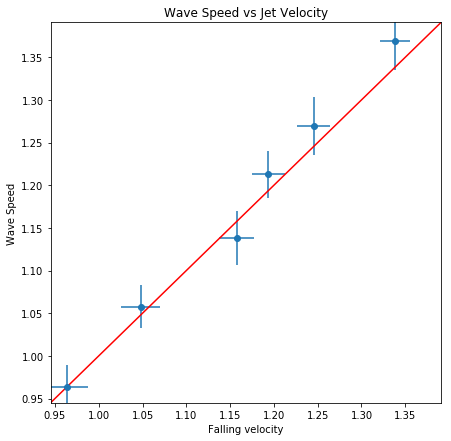

In [50]:
fig = plt.figure(figsize=(7,7))
plt.errorbar(jet_vels,peaks,yerr=2*stds,xerr=2*dev,fmt='o')
plt.plot([0,1,2],[0,1,2],'r')
plt.xlim(0.945,1.391)
plt.ylim(0.945,1.391)
plt.xlabel('Falling velocity[m/s]')
plt.ylabel('Wave Speed[m/s]')
plt.title('Wave Speed vs Jet Velocity')

In [46]:
dev

array([0.01187456, 0.0109285 , 0.00959257, 0.00989266, 0.00919482,
       0.00855613])

## Position of the crest against wavelegth and wavelength against amplitude

We intent to make a representation if the position of the waves compared with there amplitude and wavelegth. We find that for all flow rates the graphs look very similar.

Some changes are necessary in the analysis. For example, count waves only once. 

200
201


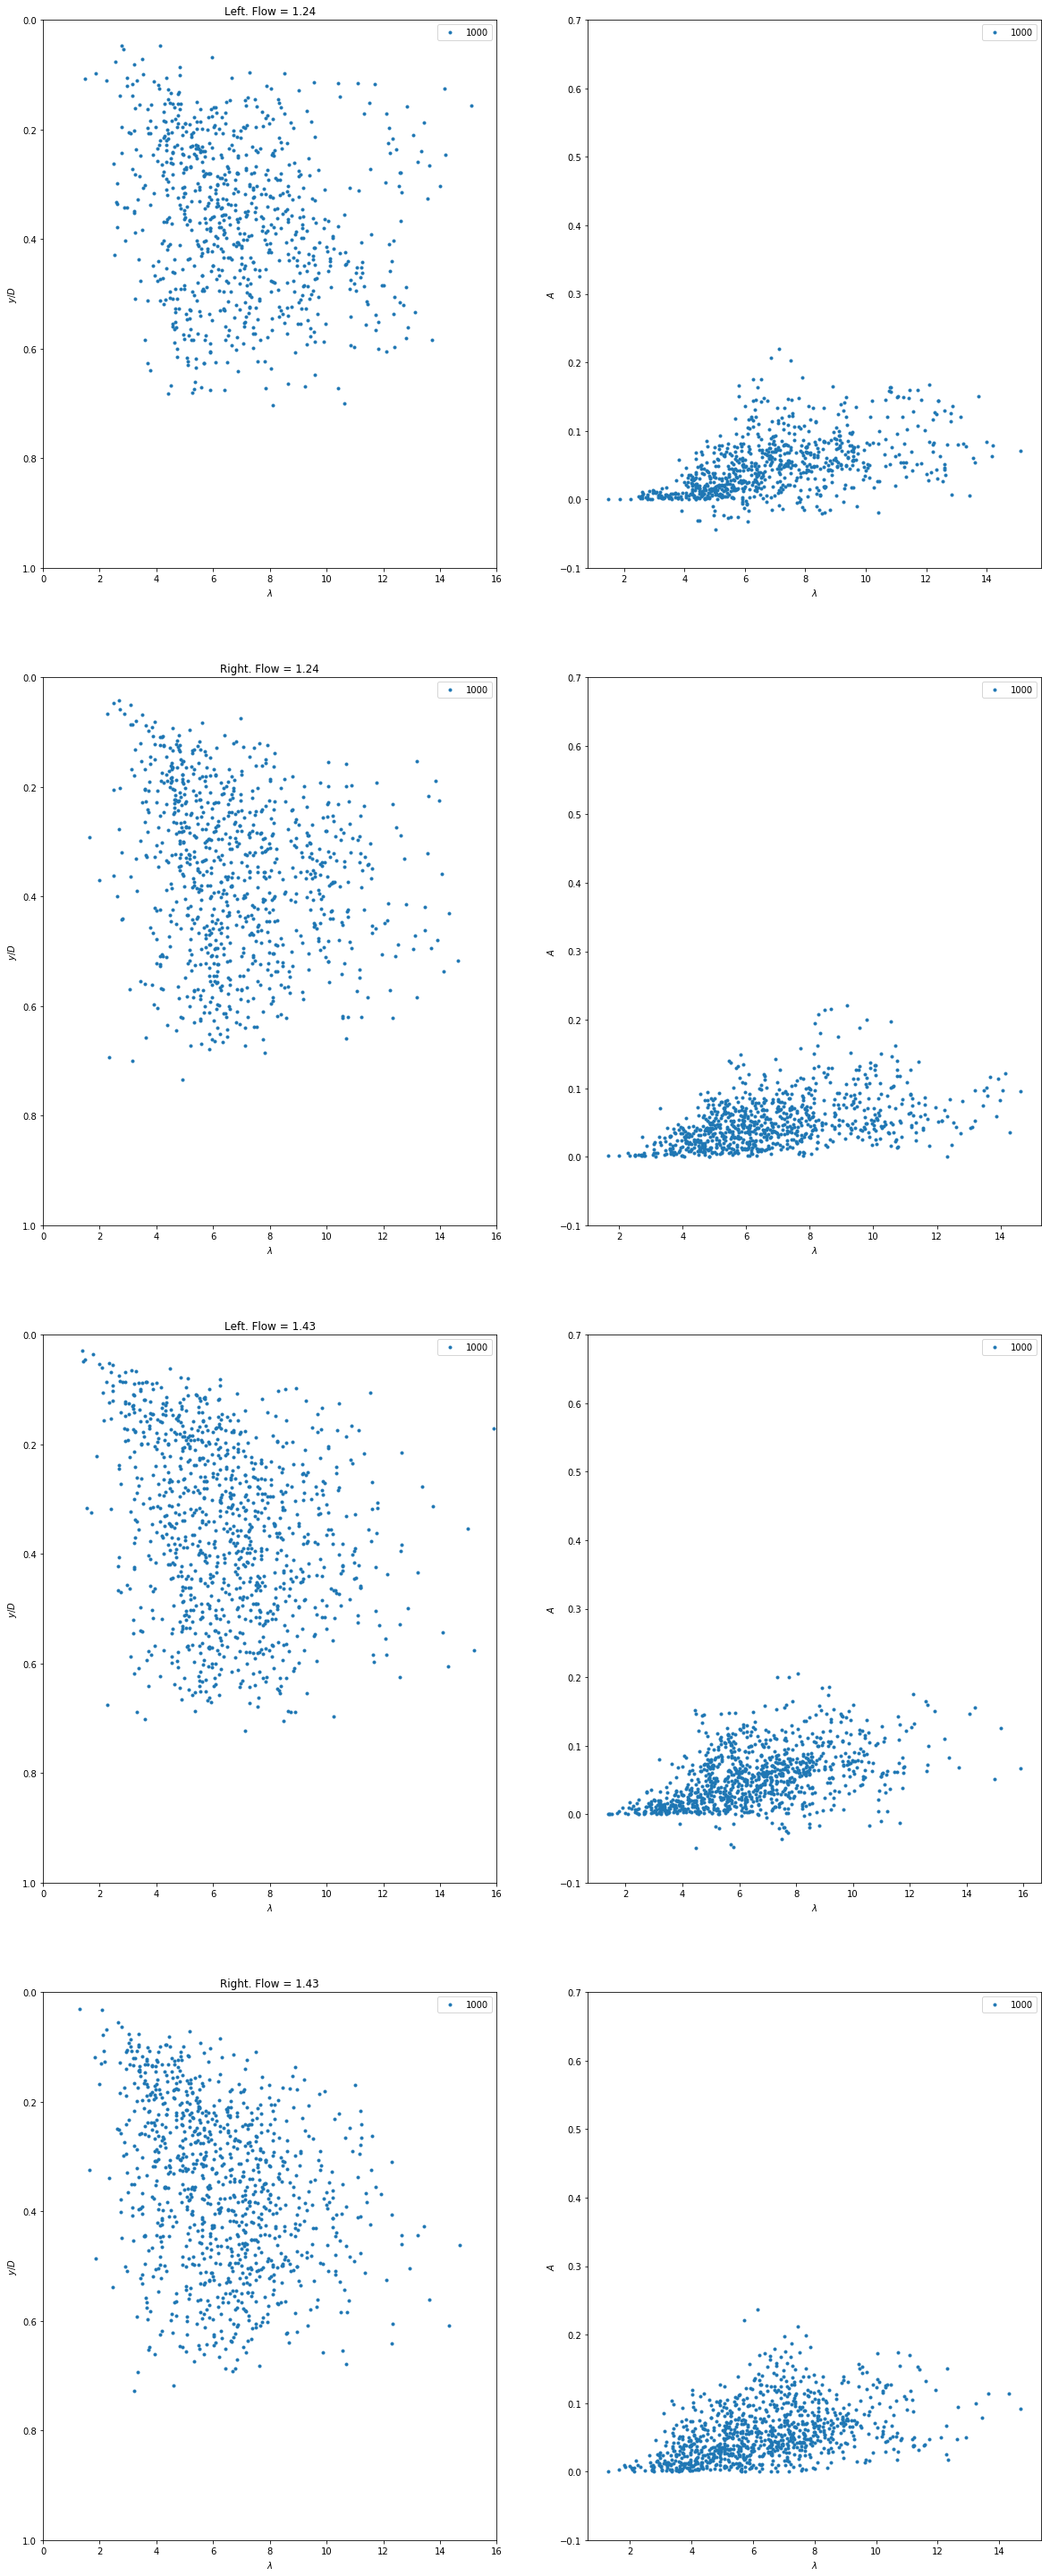

In [20]:
fig = plt.figure(figsize=(20,160))
for i in range(200,202):
    print(i)
    txt_name_r = 'sobel_right'+str(i)+'.txt'
    txt_name_l = 'sobel_left'+str(i)+'.txt'
    data_l = np.loadtxt(txt_name_l,unpack=True)
    data_r = np.loadtxt(txt_name_r,unpack=True)
    name_flow = '../flowmeter/FlowMeterData_'+str(i)+'.lvm'
    t,flow = Phot.lvm_unpack(name_flow)
    mean_flow = Phot.Mean_Flow(flow)
    
    no_images = 1000#data_l.shape[0]
    left = np.zeros((no_images,800))
    right = np.zeros((no_images,800))
    for j in range(no_images):
        wave_l = Phot.smooth(data_l[j,:800],window_len=100,window='hanning')
        wave_r = Phot.smooth(data_r[j,:800],window_len=100,window='hanning')
        left[j,:] = wave_l
        right[j,:] = wave_r
        
    indexes_left = []
    waves_left = Phot.substract_zero_crossing_time(left)
    A_left = []
    L_left = []
    crest_left = []
    no_waves_left = []

    for j in range(0,no_images):
        try:
            sep = Phot.Find_waves(waves_left[j,:],'left')
            indexes_left.append(sep)
            no_waves_left.append(len(sep)-1)
            for k in range(len(sep)-1):
                onda = waves_left[j,sep[k]:sep[k+1]]
                
                wavelength = (sep[k+1]-sep[k])/49.07  #25.6  for 185:192 
                amplitude = max(onda)/49.07  #25.6  for 185:192 
                A_left.append(amplitude)
                L_left.append(wavelength)
                crest_left.append(sep[k]+np.argmax(onda))
        except:
            indexes_left.append(0)
            no_waves_left.append(0)

    indexes_right = []
    waves_right = Phot.substract_zero_crossing_time(right)
    A_right = []
    L_right = []
    crest_right = []
    no_waves_right = []

    for j in range(0,no_images):
        try:
            sep = Phot.Find_waves(waves_right[j,:],'right',20)
            indexes_right.append(sep)
            no_waves_right.append(len(sep)-1)
            for k in range(len(sep)-1):
                onda = waves_right[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/49.07 #25.6  for 185:192 
                amplitude = abs(min(onda)/49.07) #25.6  for 185:192
                A_right.append(amplitude)
                L_right.append(wavelength)
                crest_right.append(sep[k]+np.argmin(onda))
        except:
            indexes_right.append(0)
            no_waves_right.append(0)
            
    K_left = 2*np.pi/np.array(L_left)
    K_right = 2*np.pi/np.array(L_right)
    y_left = np.array(crest_left)/800. #500 for 185:192
    y_right = np.array(crest_right)/800. #500 for 185:192
    
    plt.subplot(12,2,1+4*(i-200))
    n = no_images/1000
    for j in range(n):#(n)
        plt.plot(L_left[j*1000:(j+1)*1000-1],y_left[j*1000:(j+1)*1000-1],'.',label=str((j+1)*1000))
    plt.ylim(1,0)
    plt.xlim(0,16)
    plt.legend()
    plt.title('Left. Flow = %.2f' % mean_flow)
    plt.xlabel('$\lambda$')
    plt.ylabel('$y/D$')
    
    plt.subplot(12,2,2+4*(i-200))
    for j in range(n):
        plt.plot(L_left[j*1000:(j+1)*1000-1],A_left[j*1000:(j+1)*1000-1],'.',label=str((j+1)*1000))
    plt.xlabel('$\lambda$')
    plt.ylabel('$A$')
    plt.ylim(-0.1,0.7)
    plt.legend()
    
    plt.subplot(12,2,3+4*(i-200))
    for j in range(n): #(n)
        plt.plot(L_right[j*1000:(j+1)*1000-1],y_right[j*1000:(j+1)*1000-1],'.',label=str((j+1)*1000))
    plt.ylim(1,0)
    plt.xlim(0,16)
    plt.legend()
    plt.title('Right. Flow = %.2f' % mean_flow)
    plt.xlabel('$\lambda$')
    plt.ylabel('$y/D$')
    
    plt.subplot(12,2,4+4*(i-200))
    for j in range(n):
        plt.plot(L_right[j*1000:(j+1)*1000-1],A_right[j*1000:(j+1)*1000-1],'.',label=str((j+1)*1000))
    plt.xlabel('$\lambda$')
    plt.ylabel('$A$')
    plt.ylim(-0.1,0.7)
    plt.legend()
plt.show()

## Histogram of steepness at different flow rates

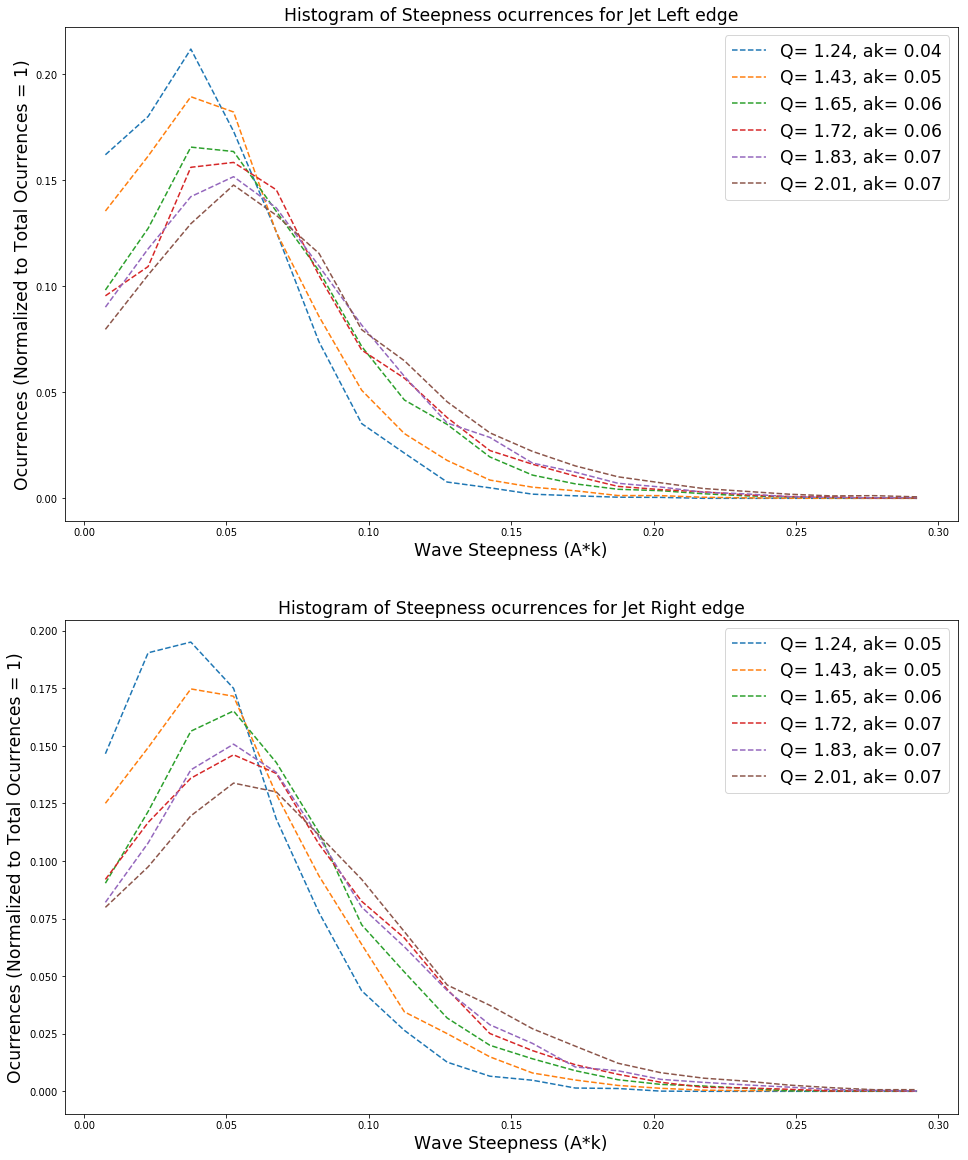

In [208]:
fig = plt.figure(figsize=(16,20))
#First axis for the left side
ax1 = plt.subplot(2,1,1)
#Second axis for the right side
ax2 = plt.subplot(2,1,2)
for i in range(200,206):
    #Flip 202 and 203 to obtain the right flow order in graphs
    if i==202:
        #Extract data Files
        txt_name_r = 'sobel_right'+str(i+1)+'.txt'
        txt_name_l = 'sobel_left'+str(i+1)+'.txt'
        data_l = np.loadtxt(txt_name_l,unpack=True)
        data_r = np.loadtxt(txt_name_r,unpack=True)
        #Extract flow data
        name_flow = '../flowmeter/FlowMeterData_'+str(i+1)+'.lvm'
        t,flow = Phot.lvm_unpack(name_flow)
        mean_flow = Phot.Mean_Flow(flow)
    elif i==203:
        #Extract data Files
        txt_name_r = 'sobel_right'+str(i-1)+'.txt'
        txt_name_l = 'sobel_left'+str(i-1)+'.txt'
        data_l = np.loadtxt(txt_name_l,unpack=True)
        data_r = np.loadtxt(txt_name_r,unpack=True)
        #Extract flow data
        name_flow = '../flowmeter/FlowMeterData_'+str(i-1)+'.lvm'
        t,flow = Phot.lvm_unpack(name_flow)
        mean_flow = Phot.Mean_Flow(flow)
    else:
        #Extract data Files
        txt_name_r = 'sobel_right'+str(i)+'.txt'
        txt_name_l = 'sobel_left'+str(i)+'.txt'
        data_l = np.loadtxt(txt_name_l,unpack=True)
        data_r = np.loadtxt(txt_name_r,unpack=True)
        #Extract flow data
        name_flow = '../flowmeter/FlowMeterData_'+str(i)+'.lvm'
        t,flow = Phot.lvm_unpack(name_flow)
        mean_flow = Phot.Mean_Flow(flow)
    #Alocat espace for data
    no_images = data_l.shape[0]
    left = np.zeros((no_images,800))
    right = np.zeros((no_images,800))
    
    for j in range(no_images):
        #Smoothing data wave by wave and fill the data matrixes
        wave_l = Phot.smooth(data_l[j,:800],window_len=100,window='hanning')
        wave_r = Phot.smooth(data_r[j,:800],window_len=100,window='hanning')
        left[j,:] = wave_l
        right[j,:] = wave_r
        
    #ANALYSIS FOR THE LEFT SIDE
    #Make zero crossings in data
    waves_left = Phot.substract_zero_crossing(left)
    #Empty list to collect variable data
    indexes_left = []
    A_left = []
    L_left = []
    crest_left = []
    no_waves_left = []
    #Loop for each timestep
    for j in range(0,no_images):
        #There are images where the output of Find_waves is empty
        # in that case we just store zeros in the corresponding lists
        try:
            #Find the troughs and collect the information
            sep = Phot.Find_waves(waves_left[j,:],'left')
            indexes_left.append(sep)
            no_waves_left.append(len(sep)-1)
            #separate each wave and calculate amplitude and wavelegth
            for k in range(len(sep)-1):
                onda = waves_left[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/49.07 #scaling dependant on images
                amplitude = abs(max(onda))/49.07     #scaling dependant on images
                A_left.append(amplitude)
                L_left.append(wavelength)
                crest_left.append(sep[k]+np.argmax(onda))
        except:
            indexes_left.append(0)
            no_waves_left.append(0)

    #ANALYSIS FOR THE RIGHT SIDE
    #Make zero crossing in data
    waves_right = Phot.substract_zero_crossing(right)
    #Empty lists to collect variable data
    indexes_right = []
    A_right = []
    L_right = []
    crest_right = []
    no_waves_right = []
    #Loop for each time step
    for j in range(0,no_images):
        #There are images where the output of Find_waves is empty
        # in that case we just store zeros in the corresponding lists
        try:
            #Find the troughs and collect the information
            sep = Phot.Find_waves(waves_right[j,:],'right')
            indexes_right.append(sep)
            no_waves_right.append(len(sep)-1)
            #separate each wave and calculate amplitude and wavelegth
            for k in range(len(sep)-1):
                onda = waves_right[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/49.07  #scaling dependant on images
                amplitude = abs(min(onda))/49.07      #scaling dependant on images
                A_right.append(amplitude)
                L_right.append(wavelength)
                crest_right.append(sep[k]+np.argmin(onda))
        except:
            indexes_right.append(0)
            no_waves_right.append(0)
    #Calculate wavenumber, steepness and their errors    
    K_left = 2*np.pi/np.array(L_left)
    K_right = 2*np.pi/np.array(L_right)
    dK_l = 0.02*K_left/np.array(L_left)
    dK_r = 0.02*K_right/np.array(L_right)
    steepness_left = A_left*K_left
    steepness_right = A_right*K_right
    dst_l = 0.02*K_left*(1.+A_left/np.array(L_left))
    dst_r = 0.02*K_right*(1.+A_right/np.array(L_right))
    #Calculate the weigth of data for histogram
    we_ak_l = 1./dst_l
    we_ak_r =1./dst_r
    #Make weigthed normalized histograms
    hist_left, bins_left = np.histogram(steepness_left,bins=20,range=(0,0.3),weights=we_ak_l,density=True)
    hist_right, bins_right = np.histogram(steepness_right,bins=20,range=(0,0.3),weights=we_ak_r,density=True)
    
    #numpy.histogram integral is one when bins are size one, so we need to
    # multiply by the bin sizes to renormalize
    norm_l = hist_left*abs(bins_left[1]-bins_left[0])
    norm_r = hist_right*abs(bins_right[1]-bins_right[0])
    #mean steepness
    ind_l = np.mean(steepness_left)
    ind_r = np.mean(steepness_right)
    center_l = (bins_left[:-1] + bins_left[1:]) / 2
    center_r = (bins_right[:-1] + bins_right[1:]) / 2
    ax1.plot(center_l,norm_l,'--',label='Q= %.2f, ak= %.2f' % (mean_flow,ind_l))
    ax2.plot(center_r,norm_r,'--',label='Q= %.2f, ak= %.2f' % (mean_flow,ind_r))
    ax1.legend(fontsize='xx-large')
    ax2.legend(fontsize='xx-large')
    ax1.set_xlabel('Wave Steepness (A*k)',fontsize='xx-large')
    ax1.set_ylabel('Ocurrences (Normalized to Total Ocurrences = 1)',fontsize='xx-large')
    ax2.set_xlabel('Wave Steepness (A*k)',fontsize='xx-large')
    ax2.set_ylabel('Ocurrences (Normalized to Total Ocurrences = 1)',fontsize='xx-large')
    ax1.set_title('Histogram of Steepness ocurrences for Jet Left edge',fontsize='xx-large')
    ax2.set_title('Histogram of Steepness ocurrences for Jet Right edge',fontsize='xx-large')
plt.show()

In [180]:
sum(norm_l)

1.0

## Histogram of symmetry

Make a histogram of the symmetry of the waves to determine if it is aslo a factor in the generation of bubbles.

The main procedure is to find the crest of the wave and then compare its position with half of the wavelength. We can make this compariosn by defining the symmetry parameter:

$$sym =\frac{X_{crest}}{\lambda / 2}=\frac{2 X_{crest}}{\lambda}$$

Then we see if $sym < 1$ the back part of the wave is smaller than the front and therefore if $sym > 1$ the front part of the wave is smaller than the back. Finally if $sym = 1$ the wave is symmentric.

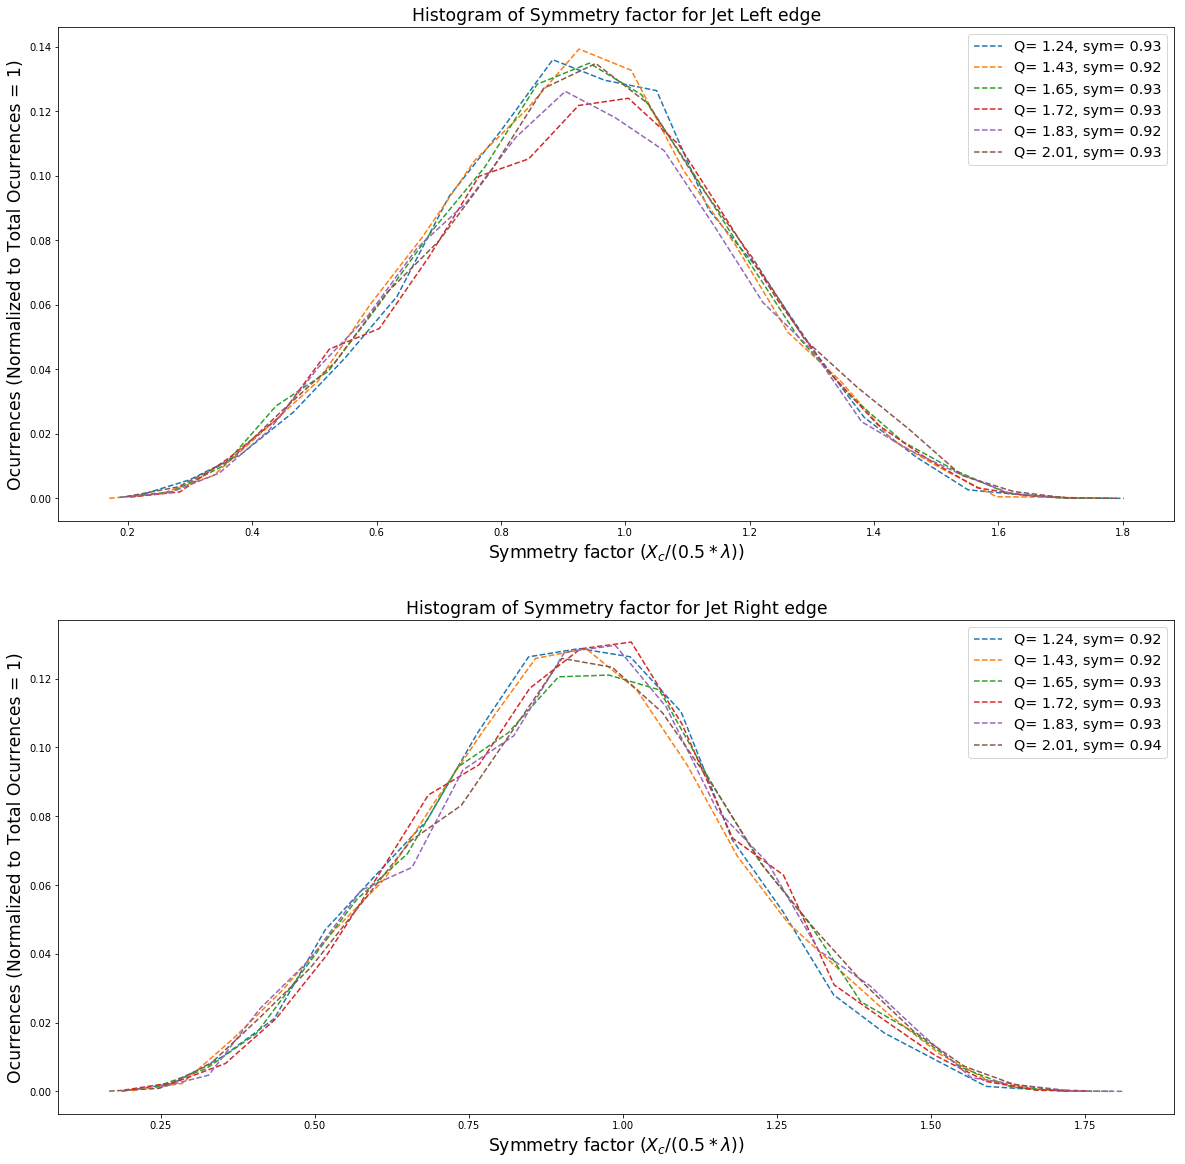

In [211]:
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
for i in range(200,206):
   #Flip 202 and 203 to obtain the right flow order in graphs
    if i==202:
        #Extract data Files
        txt_name_r = 'sobel_right'+str(i+1)+'.txt'
        txt_name_l = 'sobel_left'+str(i+1)+'.txt'
        data_l = np.loadtxt(txt_name_l,unpack=True)
        data_r = np.loadtxt(txt_name_r,unpack=True)
        #Extract flow data
        name_flow = '../flowmeter/FlowMeterData_'+str(i+1)+'.lvm'
        t,flow = Phot.lvm_unpack(name_flow)
        mean_flow = Phot.Mean_Flow(flow)
    elif i==203:
        #Extract data Files
        txt_name_r = 'sobel_right'+str(i-1)+'.txt'
        txt_name_l = 'sobel_left'+str(i-1)+'.txt'
        data_l = np.loadtxt(txt_name_l,unpack=True)
        data_r = np.loadtxt(txt_name_r,unpack=True)
        #Extract flow data
        name_flow = '../flowmeter/FlowMeterData_'+str(i-1)+'.lvm'
        t,flow = Phot.lvm_unpack(name_flow)
        mean_flow = Phot.Mean_Flow(flow)
    else:
        #Extract data Files
        txt_name_r = 'sobel_right'+str(i)+'.txt'
        txt_name_l = 'sobel_left'+str(i)+'.txt'
        data_l = np.loadtxt(txt_name_l,unpack=True)
        data_r = np.loadtxt(txt_name_r,unpack=True)
        #Extract flow data
        name_flow = '../flowmeter/FlowMeterData_'+str(i)+'.lvm'
        t,flow = Phot.lvm_unpack(name_flow)
        mean_flow = Phot.Mean_Flow(flow)
    
    no_images = data_l.shape[0]
    left = np.zeros((no_images,800))
    right = np.zeros((no_images,800))
    for j in range(no_images):
        wave_l = Phot.smooth(data_l[j,:800],window_len=100,window='hanning')
        wave_r = Phot.smooth(data_r[j,:800],window_len=100,window='hanning')
        left[j,:] = wave_l
        right[j,:] = wave_r
        
    indexes_left = []
    waves_left = Phot.substract_zero_crossing(left)
    A_left = []
    L_left = []
    no_waves_left = []
    back_left=[]

    for j in range(0,no_images):
        try:
            sep = Phot.Find_waves(waves_left[j,:],'left')
            indexes_left.append(sep)
            no_waves_left.append(len(sep)-1)
            for k in range(len(sep)-1):
                onda = waves_left[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/49.07
                
                amplitude = max(onda)/49.07
                A_left.append(amplitude)
                L_left.append(wavelength)
                back_left.append(2.*np.argmax(onda)/(wavelength*49.07))
        except:
            indexes_left.append(0)
            no_waves_left.append(0)

    indexes_right = []
    waves_right = Phot.substract_zero_crossing(right)
    A_right = []
    L_right = []
    no_waves_right = []
    back_right = []

    for j in range(0,no_images):
        try:
            sep = Phot.Find_waves(waves_right[j,:],'right')
            indexes_right.append(sep)
            no_waves_right.append(len(sep)-1)
            for k in range(len(sep)-1):
                onda = waves_right[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/49.07  
                amplitude = abs(min(onda))/49.07
                A_right.append(amplitude)
                L_right.append(wavelength)
                back_right.append(2.*np.argmin(onda)/(wavelength*49.07))
        except:
            indexes_right.append(0)
            no_waves_right.append(0)
            
    #K_left = 2*np.pi/np.array(L_left)
    #K_right = 2*np.pi/np.array(L_right)
    #steepness_left = A_left*K_left
    #steepness_right = A_right*K_right
    #back_steep_l = 2.*np.pi*np.array(A_left/(np.array(L_left)*back_left))
    #back_steep_r = 2.*np.pi*np.array(A_right/(np.array(L_right)*back_right))
    devs_left = 0.04*(1+np.array(back_left))/A_left
    devs_right = 0.04*(1+np.array(back_right))/A_right
    we_left=1./devs_left
    we_right=1./devs_right
    hist_left, bins_left = np.histogram(back_left,bins=20,weights=we_left,density=True)
    hist_right, bins_right = np.histogram(back_right,bins=20,weights=we_right,density=True)
    
    cen_l = np.average(back_left,weights=we_left)
    cen_r = np.average(back_right,weights=we_right)
    norm_l = hist_left*abs(bins_left[1]-bins_left[0])
    norm_r = hist_right*abs(bins_right[1]-bins_right[0])
    center_l = (bins_left[:-1] + bins_left[1:]) / 2
    center_r = (bins_right[:-1] + bins_right[1:]) / 2
    ax1.plot(center_l,norm_l,'--',label='Q= %.2f, sym= %.2f' % (mean_flow,cen_l))
    ax2.plot(center_r,norm_r,'--',label='Q= %.2f, sym= %.2f' % (mean_flow,cen_r))
    ax1.legend(fontsize='x-large')
    ax2.legend(fontsize='x-large')
    ax1.set_xlabel(r'Symmetry factor ($X_c/(0.5*\lambda)$)',fontsize='xx-large')
    ax1.set_ylabel('Ocurrences (Normalized to Total Ocurrences = 1)',fontsize='xx-large')
    ax2.set_xlabel(r'Symmetry factor ($X_c/(0.5*\lambda)$)',fontsize='xx-large')
    ax2.set_ylabel('Ocurrences (Normalized to Total Ocurrences = 1)',fontsize='xx-large')
    ax1.set_title('Histogram of Symmetry factor for Jet Left edge',fontsize='xx-large')
    ax2.set_title('Histogram of Symmetry factor for Jet Right edge',fontsize='xx-large')
plt.show()

In [193]:
bins_left[1]-bins_left[0]

0.08399328537170264

### Convergence of histograms in time

In [71]:
num = 201
txt_name_r = 'sobel_right'+str(num)+'.txt'
txt_name_l = 'sobel_left'+str(num)+'.txt'
data_l = np.loadtxt(txt_name_l,unpack=True)
data_r = np.loadtxt(txt_name_r,unpack=True)
name_flow = '../flowmeter/FlowMeterData_'+str(num)+'.lvm'
t,flow = Phot.lvm_unpack(name_flow)
mean_flow = Phot.Mean_Flow(flow)
    
no_images = data_l.shape[0]
left = np.zeros((no_images,800))
right = np.zeros((no_images,800))
for j in range(no_images):
    wave_l = Phot.smooth(data_l[j,:800],window_len=100,window='hanning')
    wave_r = Phot.smooth(data_r[j,:800],window_len=100,window='hanning')
    left[j,:] = wave_l
    right[j,:] = wave_r

waves_left = Phot.substract_zero_crossing(left)
waves_right = Phot.substract_zero_crossing(right)

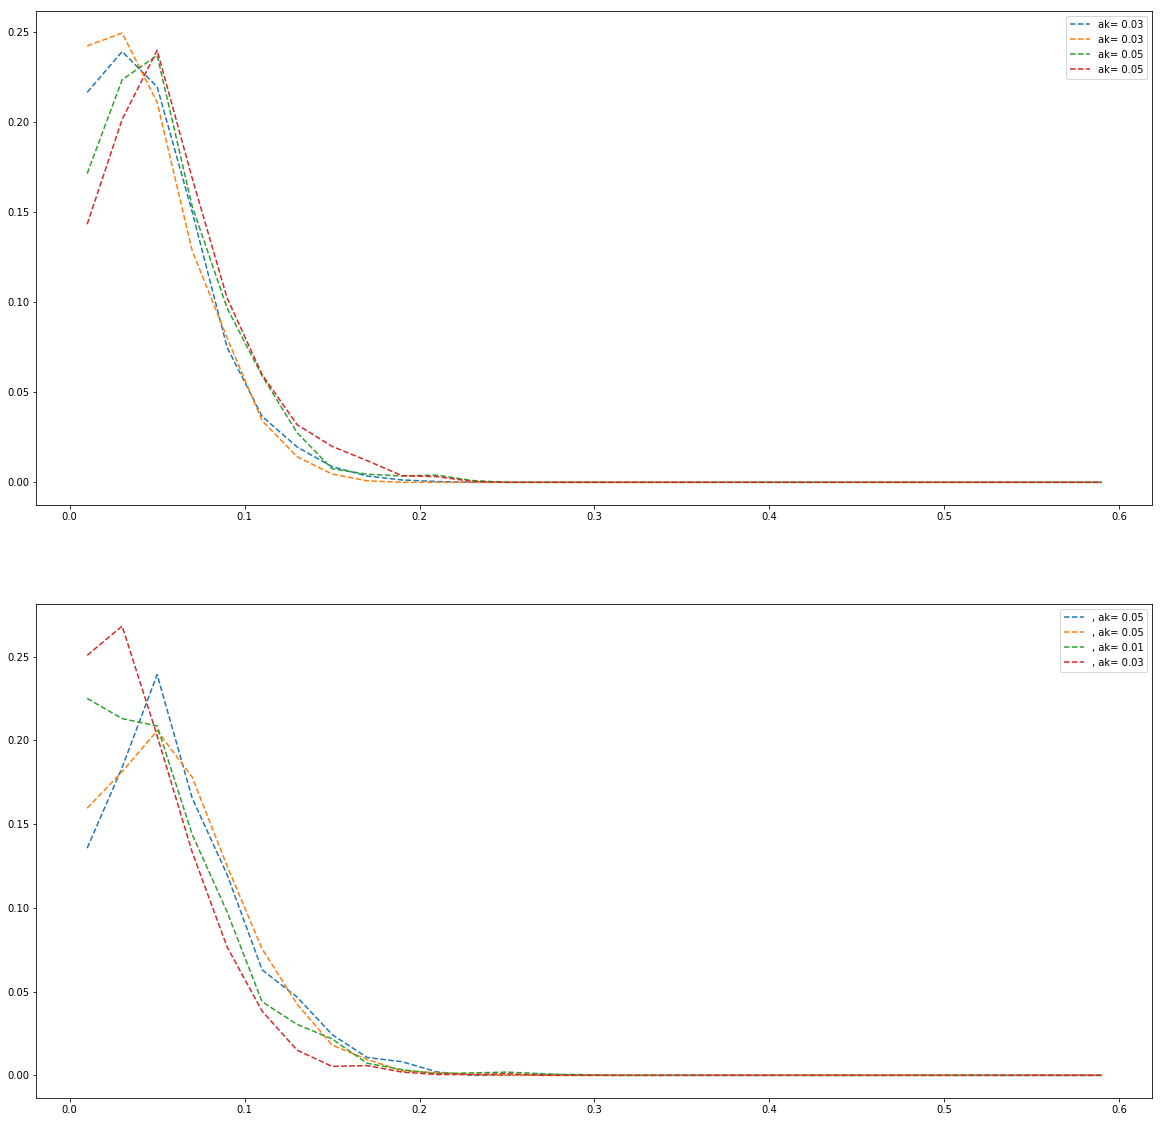

In [73]:
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

for i in range(0,4):
    indexes_left = []
    A_left = []
    L_left = []
    crest_left = []
    no_waves_left = []

    for j in range(2*i*1000,2*(i+1)*1000):
        try:
            sep = Phot.Find_waves(waves_left[j,:],'left')
            indexes_left.append(sep)
            no_waves_left.append(len(sep)-1)
            for k in range(len(sep)-1):
                onda = waves_left[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/49.07
                amplitude = max(onda)/49.07
                A_left.append(amplitude)
                L_left.append(wavelength)
                crest_left.append(sep[k]+np.argmax(onda))
        except:
            indexes_left.append(0)
            no_waves_left.append(0)
    K_left = 2*np.pi/np.array(L_left)
    steepness_left = A_left*K_left
    hist_left, bins_left = np.histogram(steepness_left,bins=30,range=(0,0.6))
    total_l = len(K_left)
    norm_l = hist_left/float(total_l)
    ind_l = np.argmax(hist_left)
    center_l = (bins_left[:-1] + bins_left[1:]) / 2
    ax1.plot(center_l,norm_l,'--',label= 'ak= %.2f' % center_l[ind_l])
    
    
    indexes_right = []
    A_right = []
    L_right = []
    crest_right = []
    no_waves_right = []

    for j in range(2*i*1000,2*(i+1)*1000):
        try:
            sep = Phot.Find_waves(waves_right[j,:],'right')
            indexes_right.append(sep)
            no_waves_right.append(len(sep)-1)
            for k in range(len(sep)-1):
                onda = waves_right[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/49.07  
                amplitude = abs(min(onda))/49.07
                A_right.append(amplitude)
                L_right.append(wavelength)
                crest_right.append(sep[k]+np.argmin(onda))
        except:
            indexes_right.append(0)
            no_waves_right.append(0)
                
    K_right = 2*np.pi/np.array(L_right)
    steepness_right = A_right*K_right
    hist_right, bins_right = np.histogram(steepness_right,bins=30,range=(0,0.6))
        
    total_r = len(K_right)
    norm_r = hist_right/float(total_r)
    ind_r = np.argmax(hist_right)
    center_r = (bins_right[:-1] + bins_right[1:]) / 2
    ax2.plot(center_r,norm_r,'--',label=', ak= %.2f' % center_r[ind_r])
    
ax1.legend()
ax2.legend()
plt.show()

## Classes for notebook importer

In [6]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [2]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [3]:
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [4]:
sys.meta_path.append(NotebookFinder())

In [7]:
import Photron_Analysis_Functions as Phot

importing Jupyter notebook from Photron Analysis Functions.ipynb
